# Procesamiento de Lenguaje Natural - **Trabajo Práctico**
# **Detectando rumores en los medios sociales**

*    El uso de las redes sociales para el descubrimiento de noticias se ha hecho muy popular en los últimos años.
*    No solo para conocer los sucesos, sino que también los periodistas las usan para recolectar noticias.

*    La velocidad de publicación de noticias durante eventos (ataques terroristas, manifestaciones, …) hace que mucha de esa información NO se encuentre verificada.

*    Entonces, detectar la información que no se encuentra verificada puede ser útil para limitar la difusión de información que puede resultar **falsa**.

#### Rumour has it...

Un rumor es una historia que circula de veracidad cuestionable. En apariencia creíble pero difícil de verificar que logra producir la sufiente “ansiedad” o “excepticismo”, lo que motiva a averiguar si es verdad o no.

*    La presencia de rumores de rumores en hordas de tweets dificulta que los usuarios puedan distinguir entre la información verificada y los rumores.


*    Hace más difícil que los periodistas puedan encontrar noticias.


## Objetivo

Detectar aquellos tweets que contienen información que todavía no ha sido verificada (los rumores), distinguiéndola de lo que no son rumores!



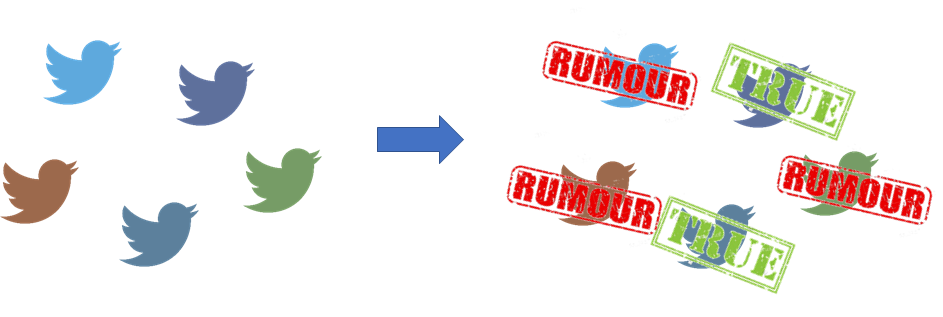

### Qué tienen que hacer?


**1.    Pre-procesamiento. Selección de features léxicas.**
2.    Features sintácticas. Pipeline.
3.    Features semánticas. Modelo de clasificación.

### Colección de datos

Las diferentes opciones de estructura de las colecciones de datos se encuentran disponibles en: 

*    [Opción 1](https://drive.google.com/uc?export=download&id=1hcdwLQEyM1wyBnomuBTDTzGXeMeyJRVD): Un directorio por cada clase de tweets.
*    [Opción 2](https://drive.google.com/uc?export=download&id=1cvQejlo_nVgVjMw8FE5UYsiFyy9203uA): Un único directorio con los tweets y las reacciones + un archivo indicando la clase de los tweets base.
*    [Opción 3](https://drive.google.com/uc?export=download&id=13POHlYNlEVJuMAXkXVNJQvjkRjAye8tL): Un único directorio, un archivo con todos los tweets base incluyendo su clase y un archivo por cada tweet con las reacciones.

Pueden elegir cualquiera de las alternativas, la que les resulte más fácil para realizar la carga de los datos.

## Carga del dataset

*Explicar brevemente la estrategia seguida, la estructura de memoria elegida para guardarlo y las características elegidas (el texto correspondiente al tweet no puede faltar) para representar los tweets. Tener en cuenta la posibilidad (o no) de considerar la información disponible en las reacciones.*

Se utilizó la tercera opción, se descargó en el entorno de colab y se pusieron los tweets en un dataframe. No se utilizaron las reacciones ya que no comprendo qué información podría obtener de las mismas y por el momento me generaría más dudas que certezas. Tengo en cuenta que siempre es necesaria más información, por lo que estos valores serán tomados en cuenta en pasos futuros, cuando se conozco más en fondo el problema a resolver y los datos que se poseen.

In [ ]:
import sys
import time
import requests
import urllib.request
import os
import json
import pandas as pd
import gzip
import shutil
from zipfile import ZipFile
from datetime import datetime

In [ ]:
#Utils

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

def descargar_archivo(url, datapath):
    if not os.path.exists(datapath): # antes de descargar el archivo controlamos que no exista
       print("File does not exist")
  
       print("Downloading file...") 
       urllib.request.urlretrieve(url, datapath,reporthook)

In [ ]:
! git clone link/to/your/repo
! git pull


fatal: repository 'link/to/your/repo' does not exist
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# descargamos el archivo invocando a la función que definimos anteriormente

url = "https://drive.google.com/uc?export=download&id=13POHlYNlEVJuMAXkXVNJQvjkRjAye8tL"

datapath = "sydneysiege-opcion3.zip"
descargar_archivo(url,datapath)

File does not exist
...-800358400%, 7 MB, 6991 KB/s, 1 seconds passed

In [ ]:
print("Extracting data...")
with ZipFile(datapath, 'r') as zipObj:
    zipObj.extractall('.')

Extracting data...


In [ ]:
def json_to_df(json_path):
  with open(json_path) as json_file:
    jarray = json.load(json_file)

  df_aux = list()
  for item in jarray:
      df_aux.append(item)

  jsondf = pd.DataFrame(df_aux)
  jsondf = jsondf.set_index('id') # seteamos el id como index del frame
  return jsondf

In [ ]:
filepath = "sydneysiege-opcion3/tweets.json"
df = json_to_df(filepath).reset_index(drop=False)

In [ ]:
df.columns.values

array(['id', 'contributors', 'truncated', 'text', 'in_reply_to_status_id',
       'favorite_count', 'source', 'retweeted', 'coordinates', 'entities',
       'in_reply_to_screen_name', 'id_str', 'retweet_count',
       'in_reply_to_user_id', 'favorited', 'user', 'geo',
       'in_reply_to_user_id_str', 'lang', 'created_at',
       'in_reply_to_status_id_str', 'place', 'rumour',
       'possibly_sensitive', 'extended_entities', 'filter_level'],
      dtype=object)

In [ ]:
df

,id,contributors,truncated,text,in_reply_to_status_id,favorite_count,source,retweeted,coordinates,entities,in_reply_to_screen_name,id_str,retweet_count,in_reply_to_user_id,favorited,user,geo,in_reply_to_user_id_str,lang,created_at,in_reply_to_status_id_str,place,rumour,possibly_sensitive,extended_entities,filter_level
0,544267656597995521,None,False,BREAKING: Hostages are being forced to hold an...,None,54,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544267656597995521,445,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:08:15 +0000 2014,None,None,yes,NaN,NaN,NaN
1,544268186292867072,None,False,BREAKING: Gunman takes hostages in cafe in Mar...,None,12,"<a href=""https://about.twitter.com/products/tw...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544268186292867072,149,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:10:22 +0000 2014,None,None,yes,False,NaN,NaN
2,544268637134393344,None,False,UPDATE: An ISIS flag is being displayed in the...,None,39,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544268637134393344,202,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:12:09 +0000 2014,None,None,yes,NaN,NaN,NaN
3,544268732046913536,None,False,#BREAKING: Hostages are being held and a siege...,None,9,"<a href=""http://www.skynews.com.au"" rel=""nofol...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544268732046913536,108,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:12:32 +0000 2014,None,None,yes,NaN,NaN,NaN
4,544269221564137472,None,False,BREAKING: A Sydney cafe at Martin Place is bei...,None,84,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544269221564137472,665,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:14:29 +0000 2014,None,None,yes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,544521260840267776,None,False,Sydney siege ends as police storm Lindt Cafe a...,None,18,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,"{'user_mentions': [], 'symbols': [], 'trends':...",None,544521260840267776,100,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:55:59 +0000 2014,None,None,no,False,NaN,low
1217,544521433473634304,None,False,"Breaking News: #SydneySiege is over, according...",None,315,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,"{'symbols': [], 'media': [{'expanded_url': 'ht...",None,544521433473634304,489,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:56:41 +0000 2014,None,None,no,False,{'media': [{'expanded_url': 'http://twitter.co...,low
1218,544521788777304064,None,False,Watch gunfire erupt and hostages flee chocolat...,None,91,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,"{'symbols': [], 'media': [{'expanded_url': 'ht...",None,544521788777304064,181,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:58:05 +0000 2014,None,None,no,False,{'media': [{'expanded_url': 'http://twitter.co...,low
1219,544521880661950464,None,False,Authorities have confirmed that #sydneysiege i...,None,35,"<a href=""https://about.twitter.com/products/tw...",False,None,"{'symbols': [], 'media': [{'expanded_url': 'ht...",None,544521880661950464,117,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:58:27 +0000 2014,None,None,no,False,{'media': [{'expanded_url': 'http://twitter.co...,low


#### Se optó por mantener las siguiente features: 
- text: el texto que tenemos que ver si es info falsa o no.
- favorite_count: mide la cantidad de favoritos que tuvo el texto. Puede ser el caso de que los textos de info real tengan mas favoritos, hay que chequear.
- retweet_count: simil anterior.
- possibly_sensitive: quizas los rumos son mas morbosos, tambien hay que ver si este atributo nos es de utilidad. Hay varios NaN, los cuales tenemos uqe tomar en cuenta.
- rumour: clase objetivo.

In [ ]:
rumour_df = df[['text', 'user', 'created_at', 'favorite_count', 'retweet_count', 'possibly_sensitive', 'rumour']]

In [ ]:
#Nos quedamos solo con el verified del usuario y con la cantidad de seguidores que tenga la acc.
#Esto es parte del pre procesamiento pero no se agrego a esa parte porque sino quedaba desordenda la 
#idea del colab planteado.

rumour_df['user_verified'] = rumour_df['user'].apply(lambda x: x['verified'])
rumour_df['user_followers'] = rumour_df['user'].apply(lambda x: x['followers_count'])
rumour_df.drop('user', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [ ]:
#Del created_at nos quedamos unicamente con la hora en el que se realizó el tweet
#Esto tambien es parte del pre procesamiento

rumour_df['created_at'] = rumour_df['created_at'].apply(lambda x: datetime.strptime(x[:-11], '%a %b %d %H:%M:%S').time().hour)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
rumour_df

,text,created_at,favorite_count,retweet_count,possibly_sensitive,rumour,user_verified,user_followers
0,BREAKING: Hostages are being forced to hold an...,23,54,445,NaN,yes,True,1672
1,BREAKING: Gunman takes hostages in cafe in Mar...,23,12,149,False,yes,True,2114
2,UPDATE: An ISIS flag is being displayed in the...,23,39,202,NaN,yes,True,26903
3,#BREAKING: Hostages are being held and a siege...,23,9,108,NaN,yes,True,150994
4,BREAKING: A Sydney cafe at Martin Place is bei...,23,84,665,NaN,yes,True,1672
...,...,...,...,...,...,...,...,...
1216,Sydney siege ends as police storm Lindt Cafe a...,15,18,100,False,no,True,2997545
1217,"Breaking News: #SydneySiege is over, according...",15,315,489,False,no,True,4636658
1218,Watch gunfire erupt and hostages flee chocolat...,15,91,181,False,no,True,1955488
1219,Authorities have confirmed that #sydneysiege i...,15,35,117,False,no,True,36137


In [ ]:
rumour_df[['rumour', 'possibly_sensitive']].groupby(by='possibly_sensitive').count()

,rumour
possibly_sensitive,
False,866
True,9


In [ ]:
rumour_df['possibly_sensitive'].isna().sum()

346

Al haber tantas filas con nan en esta columna (346 son nan sobre 1221 filas totales) se decide por eliminar esta columna. Tambien se podrían eliminar las filas, pero al ser tantos valores nan se perdería mucha información.

In [ ]:
rumour_df.drop('possibly_sensitive', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
rumour_df

,text,created_at,favorite_count,retweet_count,rumour,user_verified,user_followers
0,BREAKING: Hostages are being forced to hold an...,23,54,445,yes,True,1672
1,BREAKING: Gunman takes hostages in cafe in Mar...,23,12,149,yes,True,2114
2,UPDATE: An ISIS flag is being displayed in the...,23,39,202,yes,True,26903
3,#BREAKING: Hostages are being held and a siege...,23,9,108,yes,True,150994
4,BREAKING: A Sydney cafe at Martin Place is bei...,23,84,665,yes,True,1672
...,...,...,...,...,...,...,...
1216,Sydney siege ends as police storm Lindt Cafe a...,15,18,100,no,True,2997545
1217,"Breaking News: #SydneySiege is over, according...",15,315,489,no,True,4636658
1218,Watch gunfire erupt and hostages flee chocolat...,15,91,181,no,True,1955488
1219,Authorities have confirmed that #sydneysiege i...,15,35,117,no,True,36137


In [ ]:
#chequeamos que no hay mas nan 
rumour_df.isnull().values.any()

False

### Cálculo de estadísticas

*Calcular estadísticas referedidas a las diferentes características seleccionadas. Por ejemplo, término más frecuente, término más frecuente por clase, cantidad de verbos, sustantivos, ...*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Cantidad de favoritos entre rumor y no rumor

rumour_df[['rumour','favorite_count']].groupby(by='rumour').sum()

,favorite_count
rumour,
no,367727
yes,117448


In [ ]:
# Cantidad de retweets entre rumor y no rumor

rumour_df[['rumour','retweet_count']].groupby(by='rumour').sum()

,retweet_count
rumour,
no,342428
yes,177900


In [ ]:
# Cantidad de usuarios verificados (y no verif) entre rumor y no rumor

rumour = rumour_df[['rumour','user_verified']].loc[rumour_df['rumour'] == "yes"]
print("Rumour and verified acc:          ", len(rumour.loc[rumour['user_verified'] == True]))
print("Rumour and non verified acc:      ", len(rumour.loc[rumour['user_verified'] == False]))

rumour = rumour_df[['rumour','user_verified']].loc[rumour_df['rumour'] == "no"]
print("Non rumour and verified acc:      ", len(rumour.loc[rumour['user_verified'] == True]))
print("Non rumour and non verified acc:  ", len(rumour.loc[rumour['user_verified'] == False]))
#Si la cuenta es verificada este valor no nos va a decir mucho, pero en caso de que 
#la cuenta no sea verificada entonces es mas probable que no sea un rumor.
#Quizas la gente "comun" no suele tener intensiones de miss informar.

Rumour and verified acc:           398
Rumour and non verified acc:       124
Non rumour and verified acc:       371
Non rumour and non verified acc:   328


In [ ]:
# Cantidad de retweets entre rumor y no rumor

rumour_df[['rumour','user_followers']].groupby(by='rumour').sum()
#Vemos que hay muchos mas followers en el caso de los tweets que son rumores

,user_followers
rumour,
no,745563665
yes,1031776593


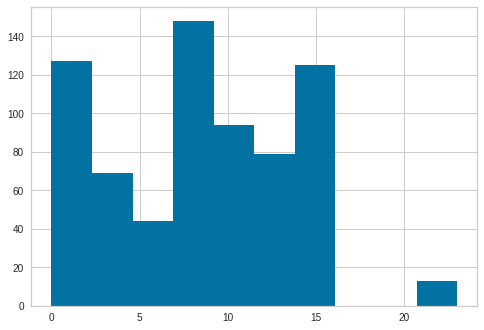

In [ ]:
#En los casos en que no es rumor se ve que mayormente se publican
#a la mañana, mientras quen los que son rumor se publican
#principalmente a las 0000. Igualmente, la principal diferencia esta en que
#los que no son rumores mayormente se publican a la mañana
rumour = rumour_df.loc[rumour_df['rumour'] == "no"]
rumour['created_at'].hist()

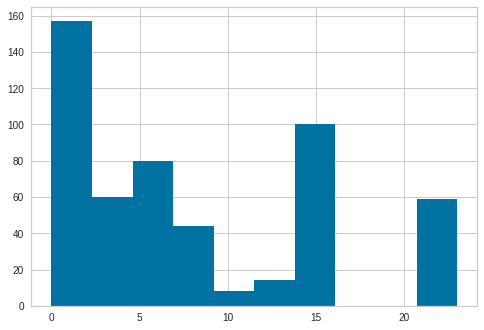

In [ ]:
rumour = rumour_df.loc[rumour_df['rumour'] == "yes"]
rumour['created_at'].hist()

Se ve que tienen más favoritos y retweet los tweets que no son rumores.

In [ ]:
def plot_freq_dist(data,list=False):
  vectorizer = CountVectorizer()
  if not list:
    X = vectorizer.fit_transform(data)
  else:
    #Pongo todas las palabras que tnego en una lista y a eso le aplico el count vectorizer
    X = vectorizer.fit_transform([x for y in [x for x in data] for x in y])
  features  = vectorizer.get_feature_names()
  visualizer = FreqDistVisualizer(features=features, n=min(20,len(features)),orient='h')
  visualizer.fit(X)

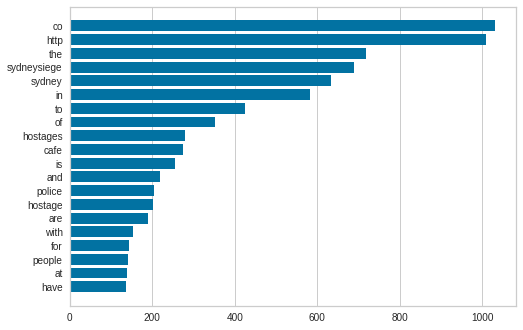

In [ ]:
plot_freq_dist(rumour_df['text'])

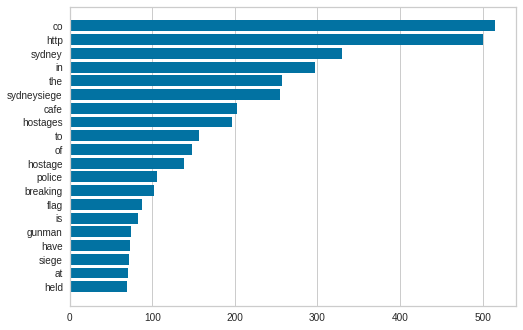

In [ ]:
plot_freq_dist(rumour_df.loc[rumour_df['rumour'] == 'yes']['text'])

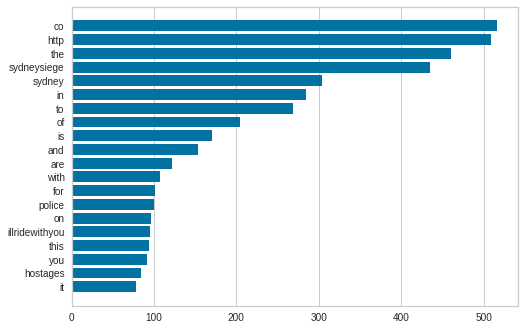

In [ ]:
plot_freq_dist(rumour_df.loc[rumour_df['rumour'] == 'no']['text'])

En las graficas de distribucion de la frecuencia de cada palabra podemos encontrar que hay varios stopwords, ademas de http.

Además, palabras asociadas al evento tambien son muy comunes, como hostage/s , police, sydney, sydneysiege, etc. las cuales no nos aportan mucha información al respecto.

Vemos que la palabra cafe se encuentra entre las palabras mas frecuentes en los rumores, por lo que esta palabra podría darnos cierta información importante.

In [ ]:
def words_dict_len(text):
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(text)
  return len(vectorizer.get_feature_names())

#cantidad de palabras diferentes que se tienen
words_dict_len(rumour_df['text'])

3535

In [ ]:
# TODO: Código para el cálculo de estadísticas de las características. Pueden usar funciones o bibliotecas que hayan ya utilizado en los módulos anteriores.

### Pre-procesamiento

*Selecccionar diferentes alternativas de pre-procesamiento y aplicar a las características seleccionadas. Para cada alternativa aplicada, explicar brevemente por qué fue utilizada.*



In [ ]:
!pip install unidecode
!pip install contractions
!pip install pyspellchecker

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 317kB 3.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81696 sha256=8a15fed7c07a99a43b6b32811299576ef5debd492d5795c018d45f56d3c533bb
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 1.9MB 2.7MB/s 


In [ ]:
import re
from unidecode import unidecode
import contractions
import nltk
from spellchecker import SpellChecker

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Seteamos el texto a lower case, ya que no nos sirve distinguir un texto en mayus a uno en minusculas
rumour_df['text'] = rumour_df['text'].apply(lambda x: x.lower())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
rumour_df.text.head()

0    breaking: hostages are being forced to hold an...
1    breaking: gunman takes hostages in cafe in mar...
2    update: an isis flag is being displayed in the...
3    #breaking: hostages are being held and a siege...
4    breaking: a sydney cafe at martin place is bei...
Name: text, dtype: object

In [ ]:
#En un  ejemplo se ve un hashtag...
rumour_df.text.iloc[0]

"breaking: hostages are being forced to hold an isis flag at a lindt cafe in sydney's martin place, as police man the doors outside #7news"

In [ ]:
#En otro ejemplo se ven sitios web...
rumour_df.text.iloc[20]

'hostages held in sydney chocolate shop forced to hold up islamic flag http://t.co/hfoy0ctlnv https://t.co/e4mpeumats'

In [ ]:
#buscamos eliminanr los sitios web ya que no nos van a aportar información relevante ya que no se posee
#una cantidad muy grande de datos. También se podrían eliminar los # y lo que continua, pero no se conoce
#el poder de los mismos (no uso twitter y desconozco que tanta informacion aportan sobre una publicacion).
#esto se debería evaluar con alguien que conozca un poco más del ambiente o, en otros casos, realizar
#análisis sobre estos datos para asegurarnos, aunque no se hizo por falta de conocimiento y tiempo.

def remove_websites(text, startWith='http'):
  try:
    out = text
    while (True):
      http_index = out.index(startWith)
      try:
        end_http_index = out[http_index:].index(" ") + http_index
      except:
        end_http_index = len(out)
      out = out[:http_index] + out[end_http_index:]
  except:
    return out

rumour_df['text'] = rumour_df['text'].apply(lambda x: remove_websites(x))
rumour_df['text'] = rumour_df['text'].apply(lambda x: remove_websites(x, startWith='www'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#vemos que se han eliminado correctamente
rumour_df.text.iloc[20]

'hostages held in sydney chocolate shop forced to hold up islamic flag  '

In [ ]:
# Unicamente dejamos el texto, eliminando todos los otros valores, entre ellos los dígitos, ya que
# no nos van a ser de utilidad para corroborar la veracidad de los post
def remove_special_characters(text):
     pattern = r'[^a-z\s]'
     text = re.sub(pattern, '', text)
     return text

rumour_df['text'] = rumour_df['text'].apply(lambda x: remove_special_characters(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#A pesar de estar en inglés, podría haber tildes ingresados, por lo que se los elimina.
#Además no nos aportan información relevante y nos agrandan el diccionario de palabras a utilizar.
rumour_df['text'] = rumour_df['text'].apply(lambda x: unidecode(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Amplio todas las contracciones.
rumour_df['text'] = rumour_df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
rumour_df['text']

0       [breaking, hostages, are, being, forced, to, h...
1       [breaking, gunman, takes, hostages, in, cafe, ...
2       [update, an, isis, flag, is, being, displayed,...
3       [breaking, hostages, are, being, held, and, a,...
4       [breaking, a, sydney, cafe, at, martin, place,...
                              ...                        
1216    [sydney, siege, ends, as, police, storm, lindt...
1217    [breaking, news, sydneysiege, is, over, accord...
1218    [watch, gunfire, erupt, and, hostages, flee, c...
1219    [authorities, have, confirmed, that, sydneysie...
1220    [watch, the, dramatic, moment, tactical, teams...
Name: text, Length: 1221, dtype: object

In [ ]:
nltk_stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
#Vamos a eliminar las stopwords de nuestro texto. Obtenemos el corpus en ingles y
#agregamos las que nos parezcan necesarias, tomando en cuenta el analisis anteriormente realizado.
#No eliminamos "cafe" ya que aparece mas en las que son rumor, por lo que nos puede ayudar a discernir
#entre ellas
#breaking aparece solo en un caso, pero es una palabra comun a la hora de anunciar noticias. Por lo que tambien
#se desea eliminarla.

nltk_stopwords.extend(["co","http","sydneysiege","sydney","hostages","police","hostage","people", 'breaking',])

In [ ]:
def remove_stopwords(text):
  return [w for w in text if not w in nltk_stopwords]

In [ ]:
#removemos los stopwords
rumour_df['text'] = rumour_df['text'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
rumour_df

,text,created_at,favorite_count,retweet_count,rumour,user_verified,user_followers
0,"[forced, hold, isis, flag, lindt, cafe, sydney...",23,54,445,yes,True,1672
1,"[gunman, takes, cafe, martin, place]",23,12,149,yes,True,2114
2,"[update, isis, flag, displayed, window, caf, s...",23,39,202,yes,True,26903
3,"[held, siege, taking, place, sydneys, lindt, c...",23,9,108,yes,True,150994
4,"[cafe, martin, place, held, inside, hands, win...",23,84,665,yes,True,1672
...,...,...,...,...,...,...,...
1216,"[siege, ends, storm, lindt, cafe, run]",15,18,100,no,True,2997545
1217,"[news, according]",15,315,489,no,True,4636658
1218,"[watch, gunfire, erupt, flee, chocolate, shop,...",15,91,181,no,True,1955488
1219,"[authorities, confirmed, storm, building]",15,35,117,no,True,36137


In [ ]:
spell = SpellChecker()

def spell_check(text_list):
  #busco corregir todas las palabras en caso de ser necesarias
  #Esto es demasiado lento, habría que buscar la forma de hacerlo más rapido. 
  return [spell.correction(w) for w in text_list]

rumour_df['text'] = rumour_df['text'].apply(lambda x: spell_check(x))

In [ ]:
rumour_df

In [ ]:
#elimino caracteres repetidos
'''
En este caso no voy a chequear si la palabra es o no correcta ya que no nos interesa.
El modelo (seguramente utilizando embeddings) no diferencia entre mood o mod, mientras que en todos los casos
se utilice del mismo modo la palabra, por lo que mantener palabras sin sentido no es un problema.
Además a continuación utilizaré stemming, por lo que solo se fijará en los afijos para eliminar y obtener
el stem. 
'''
def remove_repeated_characters(text_list):
  def remove_rep_chars(text):
    return re.sub(r'(.)\1+', r'\1', text) 
  return [remove_rep_chars(w) for w in text_list]

rumour_df['text'] = rumour_df['text'].apply(lambda x: remove_repeated_characters(x))

In [ ]:
rumour_df

In [ ]:
#A continuación el pipeline del pre procesamiento realizado.
#No se realizo antes para poder imprimir cambios en cada caso

#Se vuelven a copiar todos los métodos e importar librerias
!pip install unidecode
!pip install contractions
!pip install pyspellchecker

import re
from unidecode import unidecode
import contractions
import nltk
from spellchecker import SpellChecker

nltk.download('stopwords')

def remove_websites(text, startWith='http'):
  '''
  Se remueven los sitios web de los tweets (iniciando con http y www).
  '''
  try:
    out = text
    while (True):
      http_index = out.index(startWith)
      try:
        end_http_index = out[http_index:].index(" ") + http_index
      except:
        end_http_index = len(out)
      out = out[:http_index] + out[end_http_index:]
  except:
    return out

def remove_special_characters(text):
  '''
  Se mantienen solo las letras en el texto.
  '''
  pattern = r'[^a-z\s]'
  text = re.sub(pattern, '', text)
  return text

def remove_stopwords(text):
  '''
  Se eliminan los stopwords (nltk+agregados)
  '''
  return [w for w in text if not w in nltk_stopwords]

def spell_check(text_list):
  '''
  Se realiza un spellcheck y se corrigen las palabras
  '''
  return [spell.correction(w) for w in text_list]

def remove_repeated_characters(text_list):
  '''
  Se eliminan TODOS los caracteres repetidos
  '''
  def remove_rep_chars(text):
    return re.sub(r'(.)\1+', r'\1', text) 
  return [remove_rep_chars(w) for w in text_list]

#Definimos los stopwords y el spellcheck
nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.extend(["co","http","sydneysiege","sydney","hostages","police","hostage","people", 'breaking',])
spell = SpellChecker()


def pre_processing_pipeline(df):
  out = df.copy()

  out['user_verified'] = out['user'].apply(lambda x: x['verified'])
  out['user_followers'] = out['user'].apply(lambda x: x['followers_count'])
  out.drop('user', axis=1, inplace=True)
  out['created_at'] = out['created_at'].apply(lambda x: datetime.strptime(x[:-11], '%a %b %d %H:%M:%S').time().hour)

  #A pesar de poder unir y realizar un solo apply, se opto por dejarlo asi ya que
  #es como se realizó anteriormente.
  out['text'] = out['text'].apply(lambda x: x.lower())
  out['text'] = out['text'].apply(lambda x: remove_websites(x))
  out['text'] = out['text'].apply(lambda x: remove_websites(x, startWith='www'))
  out['text'] = out['text'].apply(lambda x: remove_special_characters(x))
  out['text'] = out['text'].apply(lambda x: unidecode(x))
  out['text'] = out['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
  out['text'] = out['text'].apply(lambda x: remove_stopwords(x))
  out['text'] = out['text'].apply(lambda x: spell_check(x))
  out['text'] = out['text'].apply(lambda x: remove_repeated_characters(x))

  return out

In [ ]:
# TODO: Aplicar diferentes pre-procesamiento a las características elegidas.

### Características léxicas

*Determinar si agregar características léxicas adicionales. Por cada tipo de característica agregada, explicar brevemente su inclusión.*


In [ ]:
from nltk.stem import SnowballStemmer

In [ ]:
#Como se dijo anteriormente, buscaremos el stem de cada palabra en lugar del lema,
#ya que no nos importa que la palabra en sí tenga sentido (nuestro predictor aprendera el sentido por su cuenta)

#Esto debería estar dentro del pipeline de pre procesamiento que se tiene
#ya que antes de ingresar al modelo este paso es un must. 
ss = SnowballStemmer(u'english')

def stem_list(text_list):
  return [ss.stem(word) for word in text_list]

rumour_df['text'] = rumour_df['text'].apply(lambda x: stem_list(x))

In [ ]:
rumour_df

In [ ]:
# TODO: Extraer características léxicas de las características textuales seleccionadas

### Re-cálculo de las estadísticas del dataset

*Recalcular las estadísticas previamente definidas.*

Solo se muestran las estadísticas que se vieron modificadas, es decir, las que tengan que ver con el texto y con las palabras del mismo.

In [ ]:
plot_freq_dist(rumour_df['text'], list=True)

In [ ]:
plot_freq_dist(rumour_df.loc[rumour_df['rumour'] == 'yes']['text'], list=True)

In [ ]:
plot_freq_dist(rumour_df.loc[rumour_df['rumour'] == 'no']['text'], list=True)

Ahora se logra observar que la palabra mas frecuente es cafe. En caso de que sea rumor se utiliza muchas mas veces que en caso contrario. Esto hay que chequear cuando se genere el modelo si no nos va a generar problemas, pesando los textos en los que aparezca la palabra cafe como un rumor aunque no lo sea.

Ahora aparecen muchas menos palabras y, además, las palabras que aparecen en la tabla de frecuencias son muy diferentes a las vistas al principio. Los principales cambios son la remocion de stopwords y la aplicación de stemming.Ademas se ve un mayor "balance" entre la cantidad de veces que aparecen las palabras.

In [ ]:
words_dict_len([x for y in [x for x in rumour_df['text']] for x in y])

Por ultimo, quiero remarcar que se observa un gran decremento en el diccionario de palabras que se tiene, pasando de 3535 a 1928 una vez aplicado todo el pre procesamiento. Este era uno de nuestros objetivos, ya que tendremos menor cantidad de parámetros que entrenar (menos palabras = menos embeddings para entrenar).

In [ ]:
# TODO: Código para replicar el cálculo de estadísticas ya realizado sobre el dataset pre-procesado. Tratar de reutilizar el código ya implementado.